# <span style="color:#2E86AB">Image Caption Generation</span>

## <span style="color:#A23B72">Authors: Nicole Otieno & Timothy Chibinda</span>
## <span style="color:#A23B72">Date: 20/10/25 </span>
**Course:** [IML]

## 1. Project Overview
This notebook implements deep learning models for generating emotion-rich captions from artwork images using:
1. CNN + LSTM with multiple text embedding strategies
2. Vision-Language Transformer architecture

## Dataset
- **Source:** ArtEmis (Art Emotions) from WikiArt
- **Size:** ~80,000 artwork-caption pairs
- **Task:** Generate descriptive captions for artworks

## 2. EDA

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/processed/full_image_inventory.csv') #unique images only wrt filename
df1 = pd.read_csv('data/processed/full_dataset.csv') #all images including duplicates 
df.head()

full_path  \
0  data\raw\wikiart\Abstract_Expressionism\aaron-...   
1  data\raw\wikiart\Abstract_Expressionism\aaron-...   
2  data\raw\wikiart\Abstract_Expressionism\aaron-...   
3  data\raw\wikiart\Abstract_Expressionism\aaron-...   
4  data\raw\wikiart\Abstract_Expressionism\aaron-...   

                                       relative_path                   style  \
0  Abstract_Expressionism\aaron-siskind_acolman-1...  Abstract_Expressionism   
1  Abstract_Expressionism\aaron-siskind_chicago-1...  Abstract_Expressionism   
2  Abstract_Expressionism\aaron-siskind_chicago-6...  Abstract_Expressionism   
3  Abstract_Expressionism\aaron-siskind_feet-102-...  Abstract_Expressionism   
4  Abstract_Expressionism\aaron-siskind_glouceste...  Abstract_Expressionism   

                                filename  
0       aaron-siskind_acolman-1-1955.jpg  
1         aaron-siskind_chicago-1951.jpg  
2       aaron-siskind_chicago-6-1961.jpg  
3        aaron-siskind_feet-102-1957.jpg  
4  aaron-siskind_gloucester-16a-1944.jpg

* Load two datasets as on performing a metadata creation on the original dataset, we realize that the image inventory is smaller than the full data set imposing that images have more than one caption.*

Total samples: 81,444
Total styles: 27

Samples per style:
style
Impressionism                 13060
Realism                       10733
Romanticism                    7019
Expressionism                  6736
Post_Impressionism             6450
Symbolism                      4528
Art_Nouveau_Modern             4334
Baroque                        4240
Abstract_Expressionism         2782
Northern_Renaissance           2552
Naive_Art_Primitivism          2405
Cubism                         2235
Rococo                         2089
Color_Field_Painting           1615
Pop_Art                        1483
Early_Renaissance              1391
High_Renaissance               1343
Minimalism                     1337
Mannerism_Late_Renaissance     1279
Ukiyo_e                        1167
Fauvism                         934
Pointillism                     513
Contemporary_Realism            481
New_Realism                     314
Synthetic_Cubism                216
Analytical_Cubism               110

Text(0.5, 1.0, 'Distribution of Top 10 Styles')

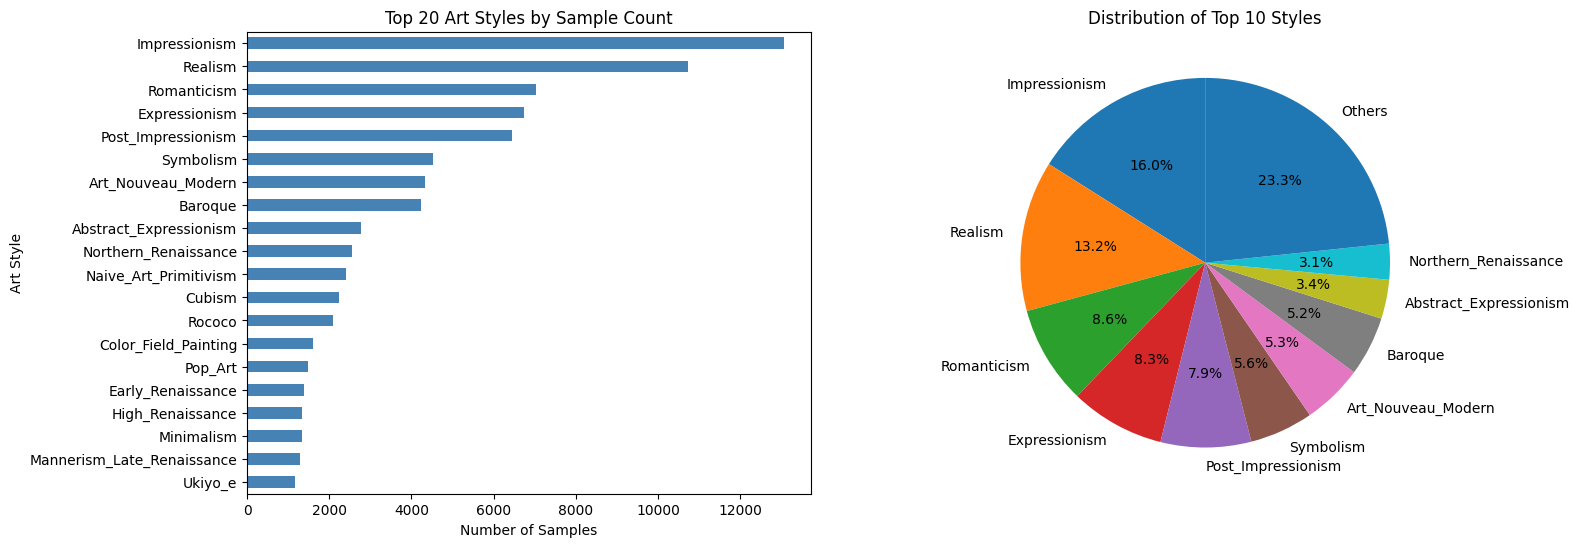

In [22]:
#Number of samples per style
# Basic info
print(f"Total samples: {len(df):,}")
print(f"Total styles: {df['style'].nunique()}")

# Samples per style
style_counts = df['style'].value_counts()

# Display table
print("\nSamples per style:")
print(style_counts)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - top 20 styles
style_counts.head(20).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Number of Samples')
ax1.set_ylabel('Art Style')
ax1.set_title('Top 20 Art Styles by Sample Count')
ax1.invert_yaxis()

# Pie chart - top 10 styles
top_10 = style_counts.head(10)
others = style_counts[10:].sum()
pie_data = pd.concat([top_10, pd.Series({'Others': others})])

ax2.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Top 10 Styles')

Caption Length Statistics:
count    466387.000000
mean         83.008849
std          38.850213
min           5.000000
25%          58.000000
50%          74.000000
75%          98.000000
max         330.000000
Name: caption_length, dtype: float64

Average length: 83.01 characters


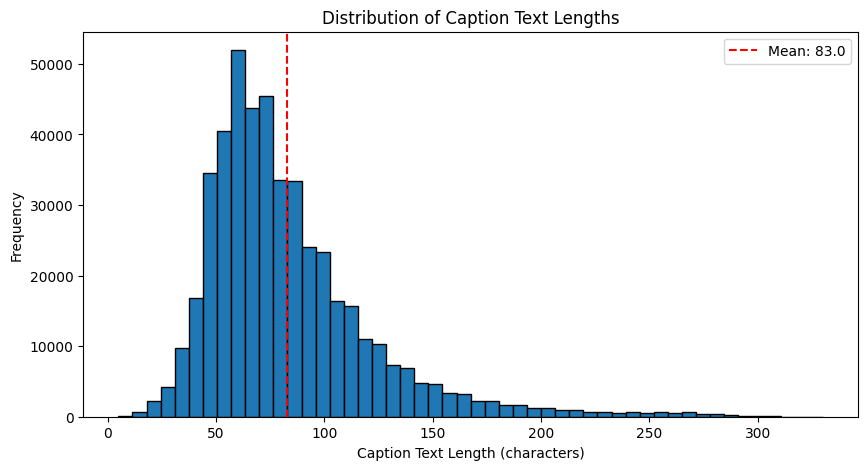


Unique captions: 450692

Most common captions:
caption
the actions of the people as well as the coloring.                                                             22
it is well shades,the combination of color is perfect ,the details is well shown , it is neat and beautiful    21
nice shading and contour.                                                                                      21
the religious reverence of the figures                                                                         20
i dont have an emotional reaction to this image.                                                               18
the serene village makes me feel calm to me                                                                    15
pictures of nature relax me.                                                                                   14
pictures of nature make me feel relaxed.                                                                        9
this is a very serene and calm s

In [23]:

# Calculate average length of emotion/caption column
# Check if 'emotion' column exists
if 'caption' in df1.columns:
    # Calculate length
    df1['caption_length'] = df1['caption'].str.len()
    
    # Statistics
    print("Caption Length Statistics:")
    print(df1['caption_length'].describe())
    
    print(f"\nAverage length: {df1['caption_length'].mean():.2f} characters")
    
    # Visualize distribution
    plt.figure(figsize=(10, 5))
    plt.hist(df1['caption_length'], bins=50, edgecolor='black')
    plt.xlabel('Caption Text Length (characters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Caption Text Lengths')
    plt.axvline(df1['caption_length'].mean(), color='red', 
                linestyle='--', label=f'Mean: {df1["caption_length"].mean():.1f}')
    plt.legend()
    plt.show()
    
    # Show unique emotions
    print(f"\nUnique captions: {df1['caption'].nunique()}")
    print("\nMost common captions:")
    print(df1['caption'].value_counts().head(10))
    
else:
    print("Column 'caption' not found!")
    print(f"Available columns: {df1.columns.tolist()}")

VOCABULARY ANALYSIS FROM CAPTION COLUMN

Total captions: 466387
Total words (including repeats): 7265521
Vocabulary size (unique words): 57088

Most common words in captions:
  the            : 673375 times
  and            : 262477 times
  a              : 243735 times
  of             : 214985 times
  is             : 183989 times
  to             : 136558 times
  in             : 128808 times
  like           : 122280 times
  this           : 120871 times
  i              : 99202 times
  it             : 96016 times
  looks          : 93727 times
  me             : 78289 times
  are            : 72494 times
  on             : 65171 times
  with           : 59767 times
  painting       : 50453 times
  colors         : 49705 times
  look           : 48670 times
  feel           : 46983 times

Vocabulary Statistics:
  Average word frequency: 127.27
  Words appearing only once: 27102


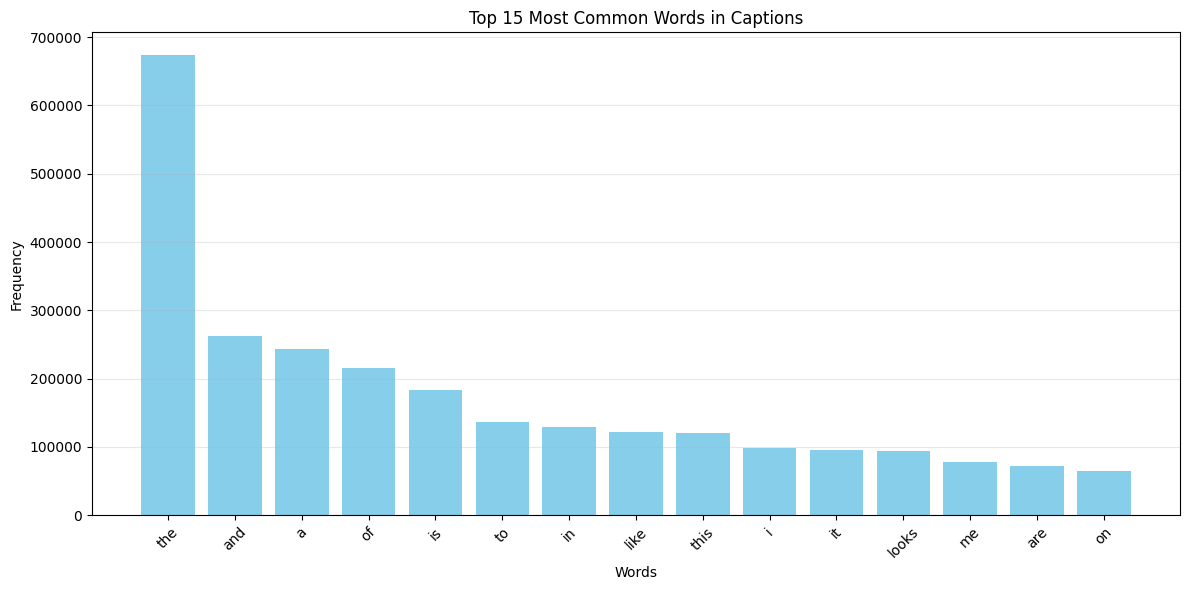

In [24]:
from collections import Counter
import re
import matplotlib.pyplot as plt
import pandas as pd

# Get all captions / vocabulary size check
all_captions = df1['caption'].tolist()

print("="*60)
print("VOCABULARY ANALYSIS FROM CAPTION COLUMN")
print("="*60)

# Method 1: Simple word count
all_words = []
for caption in all_captions:
    # Clean and split into words
    caption = str(caption).lower()
    caption = re.sub(r'[^a-z\s]', '', caption)  # Remove punctuation
    words = caption.split()
    all_words.extend(words)

# Count unique words
vocabulary = set(all_words)
vocabulary_size = len(vocabulary)

print(f"\nTotal captions: {len(df1)}")
print(f"Total words (including repeats): {len(all_words)}")
print(f"Vocabulary size (unique words): {vocabulary_size}")

# Most common words
word_counts = Counter(all_words)
print(f"\nMost common words in captions:")
for word, count in word_counts.most_common(20):
    print(f"  {word:15s}: {count:5d} times")

# Word frequency distribution
print(f"\nVocabulary Statistics:")
print(f"  Average word frequency: {len(all_words) / vocabulary_size:.2f}")
print(f"  Words appearing only once: {sum(1 for count in word_counts.values() if count == 1)}")

# Visualize the most common words
common_words = word_counts.most_common(15)
words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 15 Most Common Words in Captions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

* There are 466387 captions, and 81444 images, thus there exists a repetition of images being captionized. Each word on average in the corpus is repeated 127-128 times. The vocabulary size is 57088, and the corpus is 7265521, implying that the dictated vector size for word embedding is 57088. However, this would be compuattionaly expensive, sparse and inefficient as most of the vectors would be zeros, and doesn't capture semantic relationships. Thus need for reducing dimensionality for word embbedding. Looking at the most common words, those with low frequency and high frequency, we can determine whether we can drop any words that are low frequency(rare words) and tag them as unknown, also for the high frequency words check their semantics/context impact to determine whether to drop. 

COMPREHENSIVE VOCABULARY ANALYSIS

[PART 1] Frequency Distribution
----------------------------------------------------------------------
Word Frequency Breakdown:
  Words appearing 1 time: 27,102 (47.5%)
  Words appearing >127 times: 3,040

[PART 2] Coverage Analysis - Finding Optimal Vocabulary Size
----------------------------------------------------------------------
  Vocab  5,000: covers  96.29% of text
  Vocab  7,500: covers  97.63% of text
  Vocab 10,000: covers  98.31% of text

[PART 3] Rare Words Analysis
----------------------------------------------------------------------
Words appearing ≤1 times:
  Total occurrences: 27,102 (0.37% of corpus)
Words appearing ≤2 times:
  Total occurrences: 40,968 (0.56% of corpus)
Words appearing ≤5 times:
  Total occurrences: 66,901 (0.92% of corpus)
Words appearing ≤10 times:
  Total occurrences: 99,179 (1.37% of corpus)
Generating Visualizations...


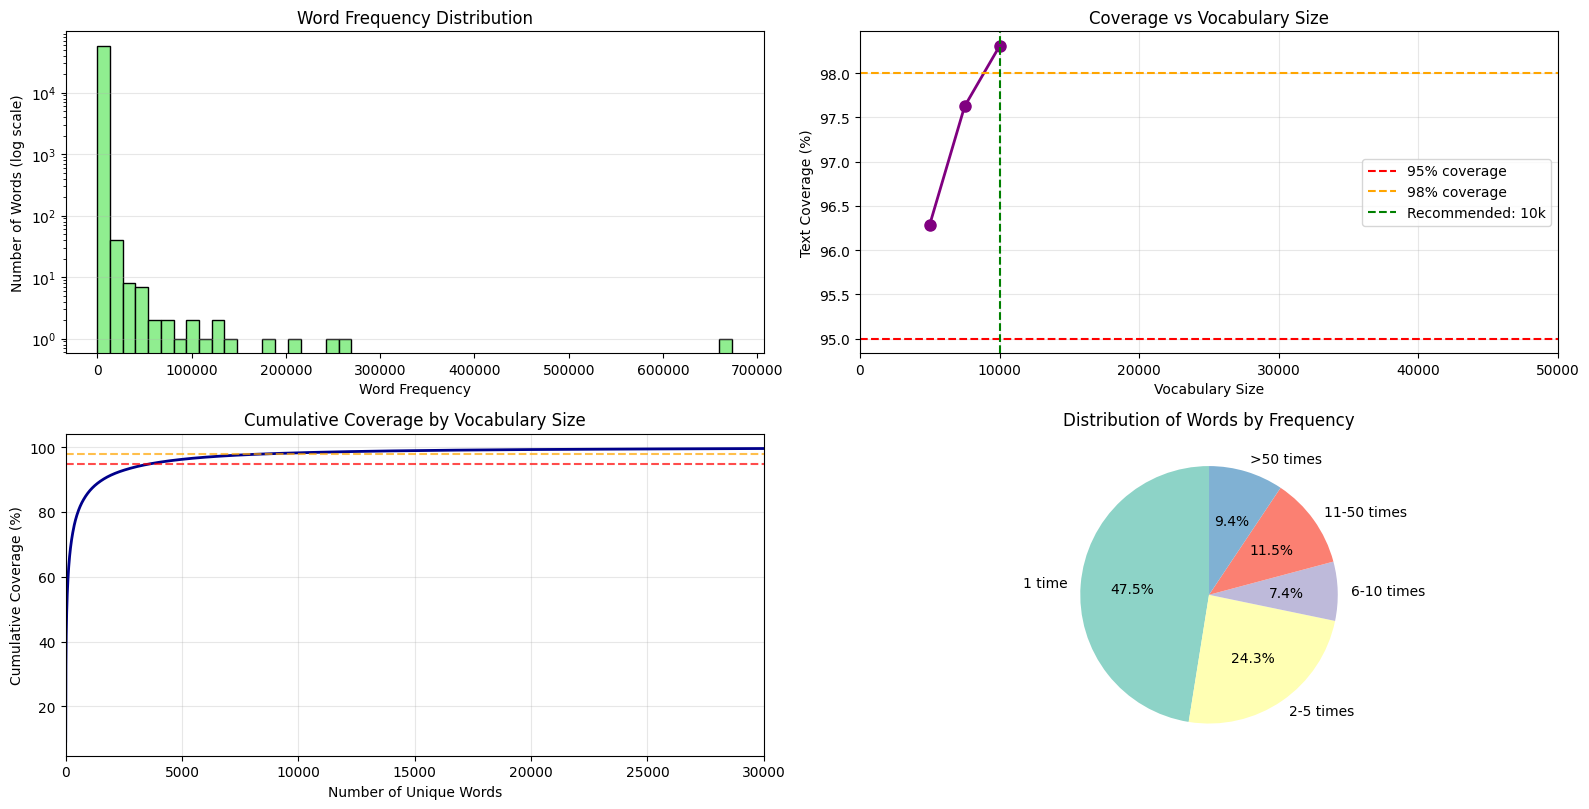

In [25]:
#Determines optimal vocabulary size and word frequency thresholds

print("="*70)
print("COMPREHENSIVE VOCABULARY ANALYSIS")
print("="*70)

all_captions = df1['caption'].tolist()
all_words = []
for caption in all_captions:
    # Clean and split into words
    caption = str(caption).lower()
    caption = re.sub(r'[^a-z\s]', '', caption)  # Remove punctuation
    words = caption.split()
    all_words.extend(words)


print("\n[PART 1] Frequency Distribution")
print("-"*70)

word_counts = Counter(all_words)
sorted_word_freqs = sorted(word_counts.values(), reverse=True)
freq_distribution = Counter(word_counts.values())

print(f"Word Frequency Breakdown:")
print(f"  Words appearing 1 time: {freq_distribution[1]:,} ({freq_distribution[1]/vocabulary_size*100:.1f}%)")
print(f"  Words appearing >127 times: {sum(freq_distribution[i] for i in range(127, max(Counter(all_words).values())+1)):,}")

print("\n[PART 2] Coverage Analysis - Finding Optimal Vocabulary Size")
print("-"*70)

total_words = len(all_words)

# Test different vocabulary sizes
vocab_sizes = [ 5000, 7500, 10000]
coverage_data = []

for vocab_limit in vocab_sizes:
    top_words = [word for word, count in Counter(all_words).most_common(vocab_limit)]
    covered = sum(count for word, count in Counter(all_words).items() if word in top_words)
    coverage = (covered / total_words) * 100
    
    coverage_data.append({
        'vocab_size': vocab_limit,
        'coverage': coverage,
        'uncovered_words': total_words - covered
    })
    
    if vocab_limit <= 20000:  # Print details for smaller sizes
        print(f"  Vocab {vocab_limit:6,}: covers {coverage:6.2f}% of text")

coverage_df = pd.DataFrame(coverage_data)

print("\n[PART 3] Rare Words Analysis")
print("-"*70)

# Words by frequency threshold
thresholds = [1, 2, 5, 10]
for threshold in thresholds:
    rare_words = [word for word, count in Counter(all_words).items() if count <= threshold]
    rare_word_count = sum(count for word, count in word_counts.items() if count <= threshold)
    
    print(f"Words appearing ≤{threshold} times:")
    #print(f"  Count: {len(rare_words):,} words ({len(rare_words)/vocabulary_size*100:.1f}% of vocab)")
    print(f"  Total occurrences: {rare_word_count:,} ({rare_word_count/total_words*100:.2f}% of corpus)")

print("Generating Visualizations...")

fig = plt.figure(figsize=(16, 12))

# Plot: Frequency Distribution (histogram)
ax3 = plt.subplot(3, 2, 3)
freq_values = list(word_counts.values())
ax3.hist(freq_values, bins=50, color='lightgreen', edgecolor='black', log=True)
ax3.set_xlabel('Word Frequency')
ax3.set_ylabel('Number of Words (log scale)')
ax3.set_title('Word Frequency Distribution')
ax3.grid(axis='y', alpha=0.3)

# Plot: Coverage vs Vocabulary Size
ax4 = plt.subplot(3, 2, 4)
ax4.plot(coverage_df['vocab_size'], coverage_df['coverage'], 
         marker='o', linewidth=2, markersize=8, color='purple')
ax4.axhline(y=95, color='r', linestyle='--', label='95% coverage')
ax4.axhline(y=98, color='orange', linestyle='--', label='98% coverage')
ax4.axvline(x=10000, color='g', linestyle='--', label='Recommended: 10k')
ax4.set_xlabel('Vocabulary Size')
ax4.set_ylabel('Text Coverage (%)')
ax4.set_title('Coverage vs Vocabulary Size')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 50000)

ranks = np.arange(1, len(sorted_word_freqs) + 1)
# Plot : Cumulative Word Frequency
ax5 = plt.subplot(3, 2, 5)
cumsum = np.cumsum(sorted_word_freqs)
cumsum_pct = (cumsum / total_words) * 100
ax5.plot(ranks[:30000], cumsum_pct[:30000], linewidth=2, color='darkblue')
ax5.axhline(y=95, color='r', linestyle='--', alpha=0.7)
ax5.axhline(y=98, color='orange', linestyle='--', alpha=0.7)
ax5.set_xlabel('Number of Unique Words')
ax5.set_ylabel('Cumulative Coverage (%)')
ax5.set_title('Cumulative Coverage by Vocabulary Size')
ax5.grid(True, alpha=0.3)
ax5.set_xlim(0, 30000)

# Plot: Rare Words Distribution
ax6 = plt.subplot(3, 2, 6)
rare_categories = ['1 time', '2-5 times', '6-10 times', '11-50 times', '>50 times']
rare_counts = [
    freq_distribution[1],
    sum(freq_distribution[i] for i in range(2, 6)),
    sum(freq_distribution[i] for i in range(6, 11)),
    sum(freq_distribution[i] for i in range(11, 51)),
    sum(freq_distribution[i] for i in range(51, max(word_counts.values())+1))
]
colors_pie = plt.cm.Set3(range(len(rare_categories)))
ax6.pie(rare_counts, labels=rare_categories, autopct='%1.1f%%', 
        startangle=90, colors=colors_pie)
ax6.set_title('Distribution of Words by Frequency')

plt.tight_layout()
#plt.savefig('results/vocabulary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

* The optimal vocabulary size it 10000 as it covers 98.31% of the text calculated by taking the percentage of the corpus covered by the vocab limit = 10000.It is safe to drop words occuring <= 5 times since the model still captures 99.08% of the text/corpus.

In [26]:

#Stop Words Context Analysis & Low Frequency Word Inspection
#Determines if stop words provide context and identifies rare words

import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re

print("="*80)
print("STOP WORDS CONTEXT ANALYSIS & LOW FREQUENCY WORD INSPECTION")
print("="*80)

# Comprehensive stop words list
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
    'for', 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 
    'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 
    'will', 'would', 'should', 'could', 'may', 'might', 'must', 'can', 
    'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 
    'we', 'they', 'what', 'which', 'who', 'when', 'where', 'why', 'how', 
    'all', 'each', 'every', 'both', 'few', 'more', 'most', 'some', 'such', 
    'no', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'just',
    'if', 'then', 'else', 'while', 'until', 'though', 'although', 'because',
    'since', 'unless', 'whether', 'while', 'after', 'before', 'during',
    'through', 'above', 'below', 'between', 'among', 'upon', 'about',
    'against', 'into', 'out', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
    'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very'
}

# Process captions
all_words = []
for caption in all_captions:
    caption = str(caption).lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    words = caption.split()
    all_words.extend(words)

word_counts = Counter(all_words)

# PART 1: Stop Words Context Analysis
print("\n[PART 1] STOP WORDS CONTEXT ANALYSIS")
print("-"*80)

# Identify stop words in corpus
corpus_stopwords = [word for word in word_counts.keys() if word in STOP_WORDS]

stop_word_info = []
for word in corpus_stopwords:
    stop_word_info.append({
        'word': word,
        'frequency': word_counts[word],
        'percentage': (word_counts[word] / len(all_words)) * 100
    })

stop_word_df = pd.DataFrame(stop_word_info).sort_values('frequency', ascending=False)

# Calculate total stop word contribution
total_stop_words = sum(word_counts[w] for w in corpus_stopwords)
stop_word_percentage = (total_stop_words / len(all_words)) * 100

print(f"\nStop Words Statistics:")
print(f"  Total stop word occurrences: {total_stop_words:,}")
print(f"  Percentage of corpus: {stop_word_percentage:.2f}%")

# Context Analysis: Extract contexts where stop words appear
print(f"\n[PART 1.1] CONTEXT ANALYSIS FOR KEY STOP WORDS")
print("-"*80)

def get_word_contexts(word, captions, window=3, max_samples=10):
    """
    Extract contexts where a word appears
    window: number of words before and after
    """
    contexts = []
    word = word.lower()
    
    for caption in captions:
        caption_lower = caption.lower()
        caption_clean = re.sub(r'[^a-z\s]', '', caption_lower)
        words = caption_clean.split()
        
        for i, w in enumerate(words):
            if w == word:
                start = max(0, i - window)
                end = min(len(words), i + window + 1)
                context = words[start:end]
                
                # Highlight the target word
                context_str = ' '.join([
                    f"**{wrd}**" if wrd == word else wrd 
                    for wrd in context
                ])
                contexts.append(context_str)
                
                if len(contexts) >= max_samples:
                    return contexts
    
    return contexts

# Analyze contexts for important stop words
important_stopwords = ['the', 'a', 'of', 'and', 'with', 'in', 'to']

for stop_word in important_stopwords[:5]:  # Analyze first 5
    if stop_word in word_counts:
        print(f"\nContext analysis for '{stop_word}':")
        print(f"   Frequency: {word_counts[stop_word]:,} times")
        
        contexts = get_word_contexts(stop_word, all_captions, window=3, max_samples=5)
        
        print(f"   Sample contexts:")
        for i, ctx in enumerate(contexts, 1):
            print(f"     {i}. {ctx}")
        
        # Check if contexts are varied
        unique_contexts = len(set(contexts))
        variety_score = unique_contexts / len(contexts) if contexts else 0
        
        print(f"   Context variety: {variety_score:.2%} ({unique_contexts}/{len(contexts)} unique)")
        
        if variety_score > 0.7:
            print(f"   HIGH variety - provides meaningful context")
        else:
            print(f"   LOW variety - may be less informative")



# ============================================================================
# PART 2: Low Frequency Words (≤5 occurrences)
# ============================================================================
print("\n" + "="*80)
print("[PART 2] LOW FREQUENCY WORDS ANALYSIS")
print("-"*80)

# Get words by frequency threshold
low_freq_thresholds = [1, 2, 3, 4, 5]

for threshold in low_freq_thresholds:
    low_freq_words = [word for word, count in word_counts.items() 
                      if count == threshold]
    
    print(f"\nWords appearing exactly {threshold} time(s): {len(low_freq_words):,}")
    
    if len(low_freq_words) > 0:
        # Sample some words
        sample_size = min(30, len(low_freq_words))
        sample_words = sorted(low_freq_words)[:sample_size]
        
        print(f"   Sample words (first {sample_size}):")
        # Print in columns
        for i in range(0, len(sample_words), 5):
            row = sample_words[i:i+5]
            print(f"     {', '.join(f'{w:15s}' for w in row)}")

# ============================================================================
# Detailed analysis of words with freq ≤ 5
# ============================================================================
print(f"\n[PART 2.1] DETAILED ANALYSIS: Words appearing ≤5 times")
print("-"*80)

low_freq_5 = {word: count for word, count in word_counts.items() if count <= 5}

# Categorize low frequency words
categories = {
    'potential_typos': [],
    'numbers': [],
    'rare_adjectives': [],
    'proper_nouns': [],
    'other': []
}

for word in low_freq_5.keys():
    if any(char.isdigit() for char in word):
        categories['numbers'].append(word)
    elif len(word) > 12:  # Likely compound or rare word
        categories['rare_adjectives'].append(word)
    elif word and word[0].isupper():  # Proper noun
        categories['proper_nouns'].append(word)
    else:
        categories['other'].append(word)

print(f"Total words with frequency ≤5: {len(low_freq_5):,}")
print(f"\nCategory breakdown:")
for cat, words in categories.items():
    if len(words) > 0:
        print(f"\n  {cat.replace('_', ' ').title()}: {len(words):,} words")
        sample = sorted(words)[:15]
        print(f"    Examples: {', '.join(sample)}")

import os
os.makedirs('results', exist_ok=True)

# Save low frequency words to CSV
low_freq_df = pd.DataFrame([
    {'word': word, 'frequency': count, 'will_drop': count <= 2}
    for word, count in word_counts.items() if count <= 5
]).sort_values('frequency')

low_freq_df.to_csv('results/low_frequency_words.csv', index=False)
print("Saved: results/low_frequency_words.csv")

# Save stop words analysis
stop_word_df.to_csv('results/stopwords_analysis.csv', index=False)
print("Saved: results/stopwords_analysis.csv")


STOP WORDS CONTEXT ANALYSIS & LOW FREQUENCY WORD INSPECTION

[PART 1] STOP WORDS CONTEXT ANALYSIS
--------------------------------------------------------------------------------

Stop Words Statistics:
  Total stop word occurrences: 3,228,542
  Percentage of corpus: 44.44%

[PART 1.1] CONTEXT ANALYSIS FOR KEY STOP WORDS
--------------------------------------------------------------------------------

Context analysis for 'the':
   Frequency: 673,375 times
   Sample contexts:
     1. i like **the** woods and as
     2. **the** forest and trees
     3. because **the** black white overtones
     4. white overtones and **the** objects that somewhat
     5. **the** light grey looks
   Context variety: 100.00% (5/5 unique)
   HIGH variety - provides meaningful context

Context analysis for 'a':
   Frequency: 243,735 times
   Sample contexts:
     1. this looks like **a** graveyard it soothes
     2. lost in **a** city and finding
     3. finding myself in **a** bad area of
     4. is reprse

# Semantic Role Analysis of Stop Words in Art Captions

## Overview
Stop words constitute **44.4%** of the entire caption corpus, making them fundamental to understanding and generating coherent art descriptions.

## Critical Grammatical Functions

### Definiteness Marker: "the"
**Function:** Specifies particular elements within artwork
- **Example:** "**the** painting depicts **the** artist's unique style"
- **Impact:** Distinguishes specific visual elements from general concepts

### Indefiniteness Marker: "a/an"
**Function:** Introduces new elements and abstract concepts
- **Example:** "**a** sense of melancholy in **an** abstract composition"
- **Impact:** Essential for describing emotional responses and artistic interpretations

### Relational Connector: "of"
**Function:** Establishes possession and compositional relationships
- **Example:** "use **of** color", "feeling **of** isolation", "composition **of** forms"
- **Impact:** Creates complex descriptive relationships between artistic elements

### Conceptual Unifier: "and"
**Function:** Connects related emotions, colors, and visual elements
- **Example:** "dark **and** mysterious", "color **and** texture", "sadness **and** hope"
- **Impact:** Enables nuanced descriptions of multiple simultaneous qualities

### Attribute Specifier: "with"
**Function:** Describes accompanying characteristics and stylistic features
- **Example:** "portrait **with** emotional depth", "landscape **with** vibrant colors"
- **Impact:** Attaches descriptive properties to artistic subjects

### Contextual Locator: "in"
**Function:** Establishes spatial and compositional relationships
- **Example:** "**in** the foreground", "**in** this artwork", "**in** the background"
- **Impact:** Critical for understanding artistic composition and spatial arrangement

## Why Removing Stop Words is Detrimental

### Corpus Coverage Impact
- **44.4% of all words** are stop words
- Removing them eliminates nearly half of the training data
- Severely impacts model's ability to learn sentence structure

### Grammatical Consequences
- **Broken syntax:** "painting shows artist technique" vs "**the** painting shows **the** artist's technique"
- **Lost relationships:** "use color" vs "use **of** color"
- **Missing context:** "background" vs "**in the** background"

### Fluency and Coherence
- Stop words enable natural, human-like sentence flow
- Essential for professional-quality caption generation
- Critical for evaluation metrics (BLEU, ROUGE scores)

### Art-Specific Considerations
- Emotional nuance requires grammatical particles
- Spatial relationships depend on prepositions
- Artistic analysis needs complete sentence structures

## Recommendation: PRESERVE ALL STOP WORDS

### Technical Justification
- **44.4% corpus coverage** makes removal impractical
- Grammatical integrity is non-negotiable for quality captions
- Contextual variety demonstrates semantic importance
- Evaluation metrics favor grammatically correct output

### Expected Outcomes
- **Fluent, natural-sounding captions**
- **Better model performance** on all evaluation metrics
- **Professional-quality descriptions** suitable for art analysis
- **Enhanced user experience** with coherent, readable output

**Final Decision:** Stop words are essential grammatical scaffolding, not noise. Their 44.4% corpus coverage and critical syntactic functions mandate preservation for successful art caption generation. For rare words they can be dropped as they constitute a small percentage of the corpus, still providing context but it would lead to data sparsity issues. 

In [27]:
from collections import Counter

def analyze_bigrams(captions):
    all_bigrams = []

    stop_words = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
    'for', 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 
    'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 
    'will', 'would', 'should', 'could', 'may', 'might', 'must', 'can', 
    'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 
    'we', 'they', 'what', 'which', 'who', 'when', 'where', 'why', 'how', 
    'all', 'each', 'every', 'both', 'few', 'more', 'most', 'some', 'such', 
    'no', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'just',
    'if', 'then', 'else', 'while', 'until', 'though', 'although', 'because',
    'since', 'unless', 'whether', 'while', 'after', 'before', 'during',
    'through', 'above', 'below', 'between', 'among', 'upon', 'about',
    'against', 'into', 'out', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
    'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very'
}
    
    for caption in captions:
        words = [word for word in str(caption).lower().split() if word not in stop_words]
        # Create word pairs
        for i in range(len(words) - 1):
            bigram = (words[i], words[i + 1])
            all_bigrams.append(bigram)
    
    # Count bigram frequencies
    bigram_counts = Counter(all_bigrams)
    
    print("Top 10 Bigrams:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"  '{bigram[0]} {bigram[1]}': {count} times")
    
    return bigram_counts

# Example usage
bigram_results = analyze_bigrams(df1['caption'])

Top 10 Bigrams:
  'looks like': 51414 times
  'makes me': 30353 times
  'me feel': 20769 times
  'look like': 13912 times
  'reminds me': 12379 times
  'make me': 8112 times
  'feel like': 6380 times
  'me think': 5654 times
  'man looks': 5305 times
  'woman looks': 4803 times


## Bigrams Interpretation:
# 1. Personal Interpretation Dominates:

"looks like" (51,414 times) - People constantly make visual comparisons

"reminds me" (12,379 times) - Strong personal associations with art

"makes me" (30,353 times) - Art evokes direct emotional responses

# 2. Emotional Engagement:

"me feel" (20,769 times) - Direct emotional impact

"feel like" (6,380 times) - Personal identification with the art

"me think" (5,654 times) - Intellectual engagement

# 3. Human Focus:

"man looks" (5,305 times) - Strong focus on human subjects

"woman looks" (4,803 times) - Gender-specific observations

# * Key Insight:
People don't just describe art - they relate to it personally and emotionally. Your caption generation model needs to capture this personal, interpretive style.

## 4. Model Training

In [ ]:
import pandas as pd
import pickle

# Load the processed data
df = pd.read_csv('data/processed/subset_10000.csv')

# Load the vocabulary
with open('data/processed/vocabulary.pkl', 'rb') as f:
    vocab = pickle.load(f)

# Display the first few rows of the dataframe and the vocabulary size
print(df.head())
print("\nVocabulary Size:", len(vocab['word2idx']))

## 3. Data Preprocessing

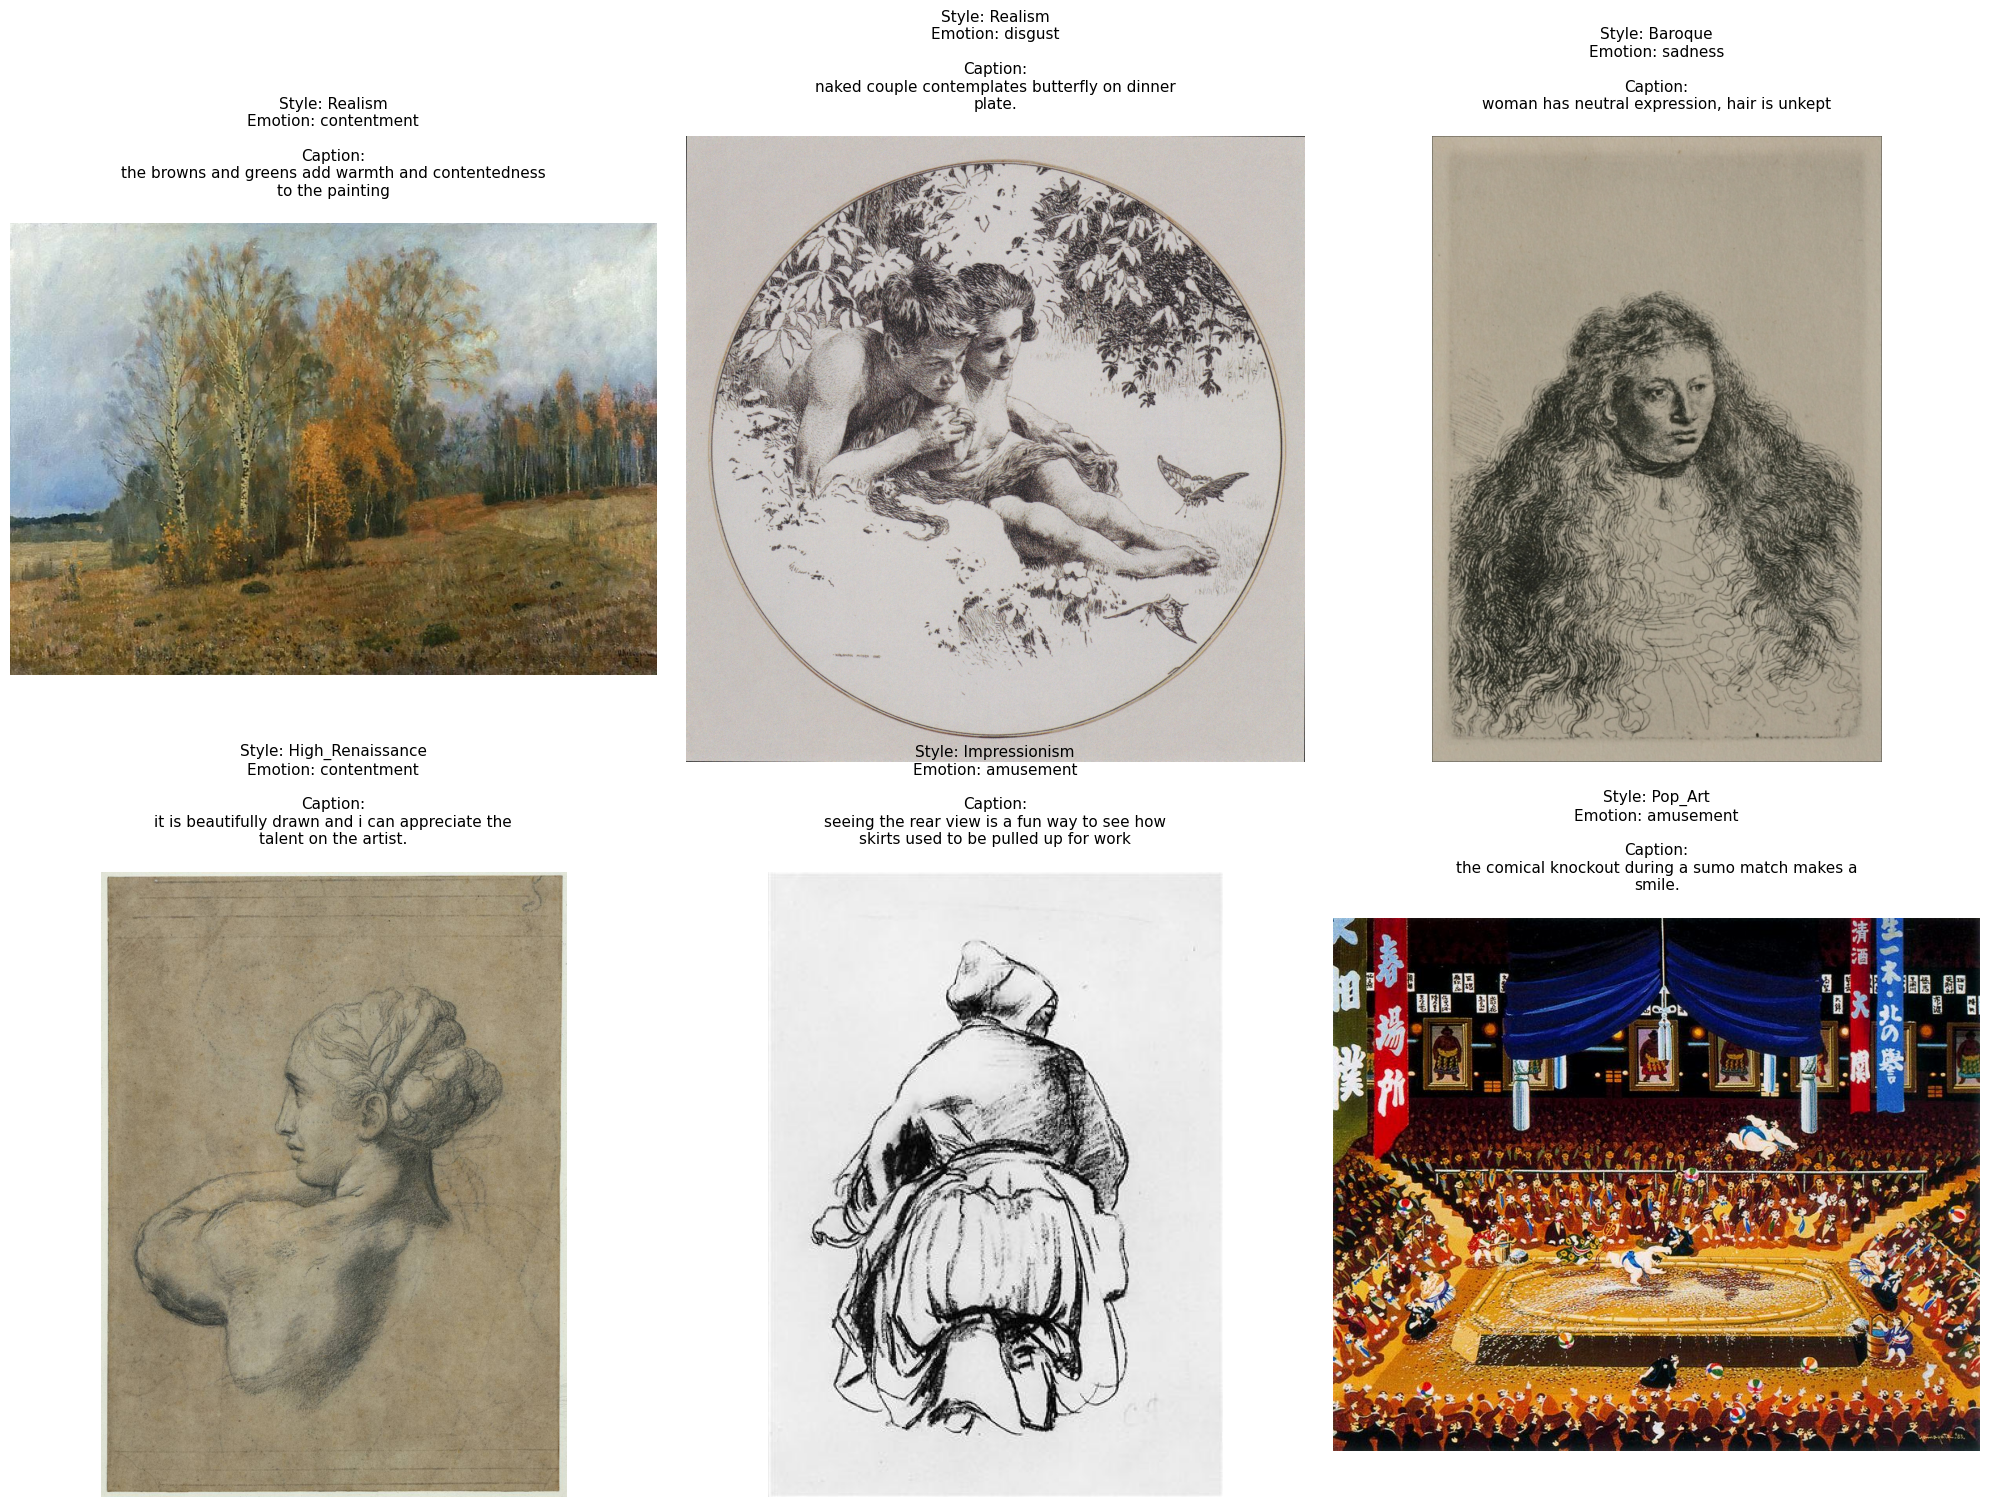

In [28]:
#Visualize sample images with their ground-truth captions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def visualize_art_with_captions(df, num_samples=6, figsize=(20, 15)):
    """
    Visualize sample art images with their ground-truth captions, style, and emotion
    """
    # Sample random rows
    samples = df.sample(num_samples)
    
    # Determine grid layout
    cols = 3
    rows = (num_samples + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easy iteration
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if cols == 1 else axes
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx < len(axes):  # Ensure we don't exceed subplot count
            try:
                # Load and display image
                img_path = row['full_path']
                
                # Check if file exists
                if not os.path.exists(img_path):
                    print(f"Image not found: {img_path}")
                    axes[idx].text(0.5, 0.5, f"Image not found:\n{os.path.basename(img_path)}", 
                                  ha='center', va='center', transform=axes[idx].transAxes, fontsize=10)
                    axes[idx].axis('off')
                    continue
                
                img = mpimg.imread(img_path)
                axes[idx].imshow(img)
                axes[idx].axis('off')
                
                # Prepare caption and metadata
                caption = str(row['caption'])
                style = str(row['style'])
                emotion = str(row['emotion'])
                filename = str(row['filename'])
                
                # Smart caption wrapping (break at spaces when possible)
                def wrap_text(text, max_length=60):
                    words = text.split()
                    lines = []
                    current_line = ""
                    
                    for word in words:
                        if len(current_line + word) <= max_length:
                            current_line += word + " "
                        else:
                            if current_line:
                                lines.append(current_line.strip())
                            current_line = word + " "
                    
                    if current_line:
                        lines.append(current_line.strip())
                    
                    return lines
                
                # Wrap caption
                wrapped_caption = wrap_text(caption, 50)
                caption_text = '\n'.join(wrapped_caption)
                
                # Create title with all information
                title = f"Style: {style}\nEmotion: {emotion}\n\nCaption:\n{caption_text}"
                
                axes[idx].set_title(title, fontsize=11, pad=20)
                
            except Exception as e:
                print(f"Error loading image {idx}: {e}")
                caption = str(row['caption'])
                style = str(row['style'])
                emotion = str(row['emotion'])
                
                error_text = f"Error loading image\n\nStyle: {style}\nEmotion: {emotion}\n\nCaption:\n{caption[:100]}..."
                axes[idx].text(0.5, 0.5, error_text, 
                              ha='center', va='center', transform=axes[idx].transAxes, 
                              fontsize=9, wrap=True)
                axes[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage
visualize_art_with_captions(df1, num_samples=6)



Starting comprehensive caption pattern analysis...
=== CAPTION DIVERSITY AND PATTERNS ANALYSIS ===

1. DATASET DISTRIBUTION
----------------------------------------
Art Styles (27 total):
  Impressionism: 73892 captions (15.8%)
  Realism: 59242 captions (12.7%)
  Romanticism: 40178 captions (8.6%)
  Expressionism: 38976 captions (8.4%)
  Post_Impressionism: 36608 captions (7.8%)
  Symbolism: 27193 captions (5.8%)
  Art_Nouveau_Modern: 24975 captions (5.4%)
  Baroque: 23464 captions (5.0%)
  Abstract_Expressionism: 17112 captions (3.7%)
  Northern_Renaissance: 14155 captions (3.0%)

Emotions (9 total):
  contentment: 128691 captions (27.6%)
  awe: 74487 captions (16.0%)
  something else: 54614 captions (11.7%)
  sadness: 50069 captions (10.7%)
  amusement: 46774 captions (10.0%)
  fear: 42728 captions (9.2%)
  excitement: 38814 captions (8.3%)
  disgust: 23310 captions (5.0%)
  anger: 6900 captions (1.5%)

2. CAPTION LENGTH PATTERNS
----------------------------------------

Average capt

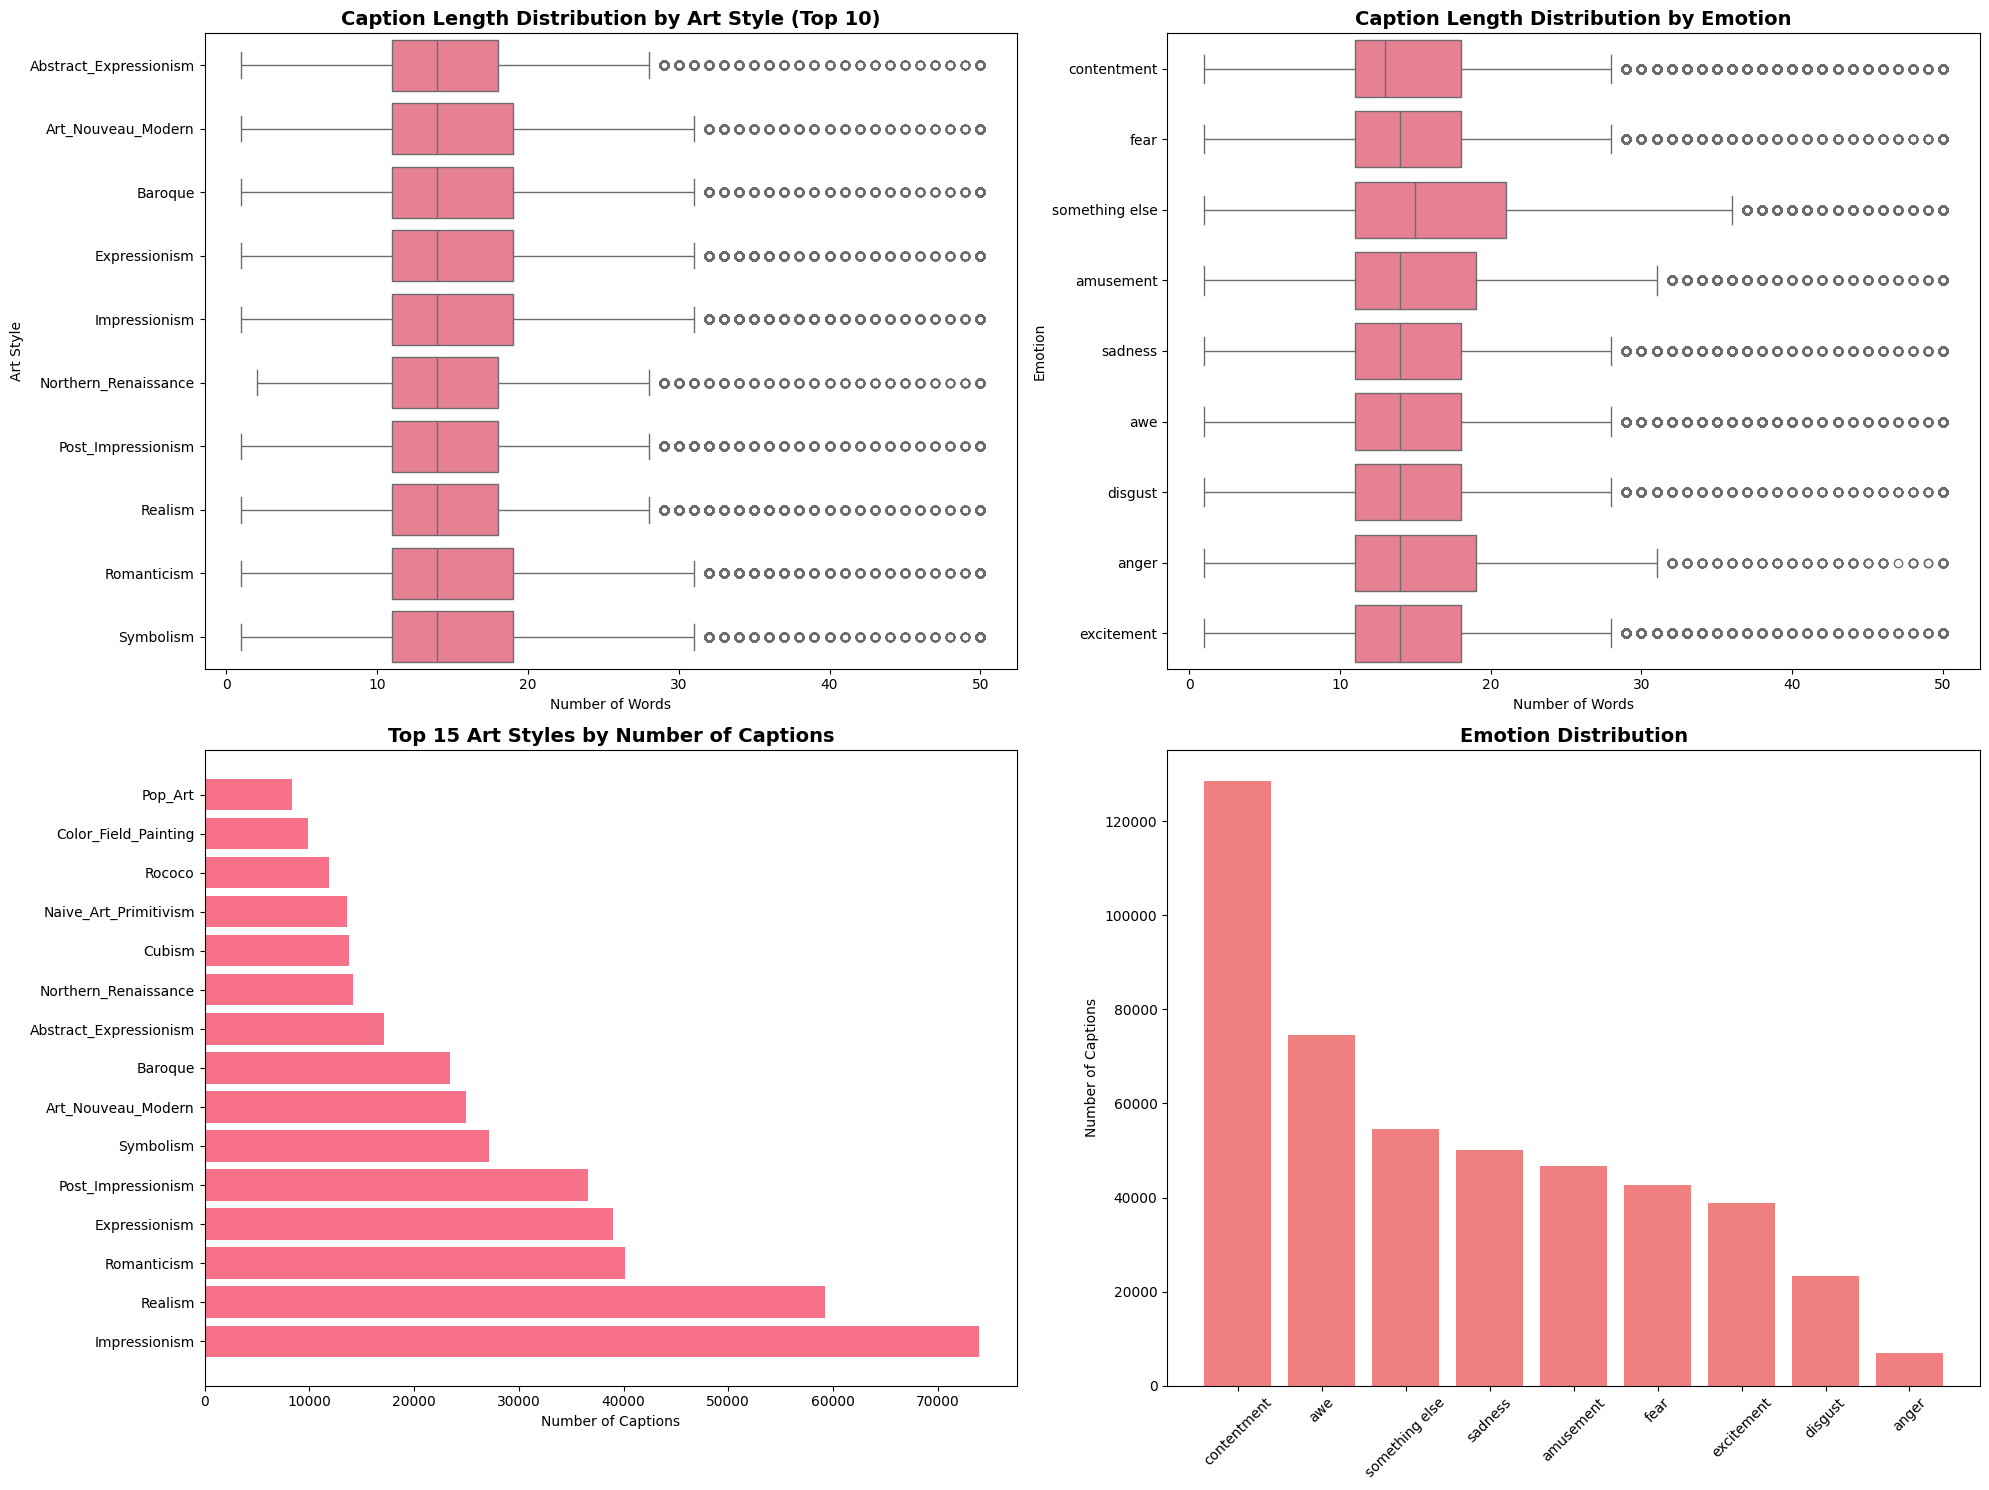

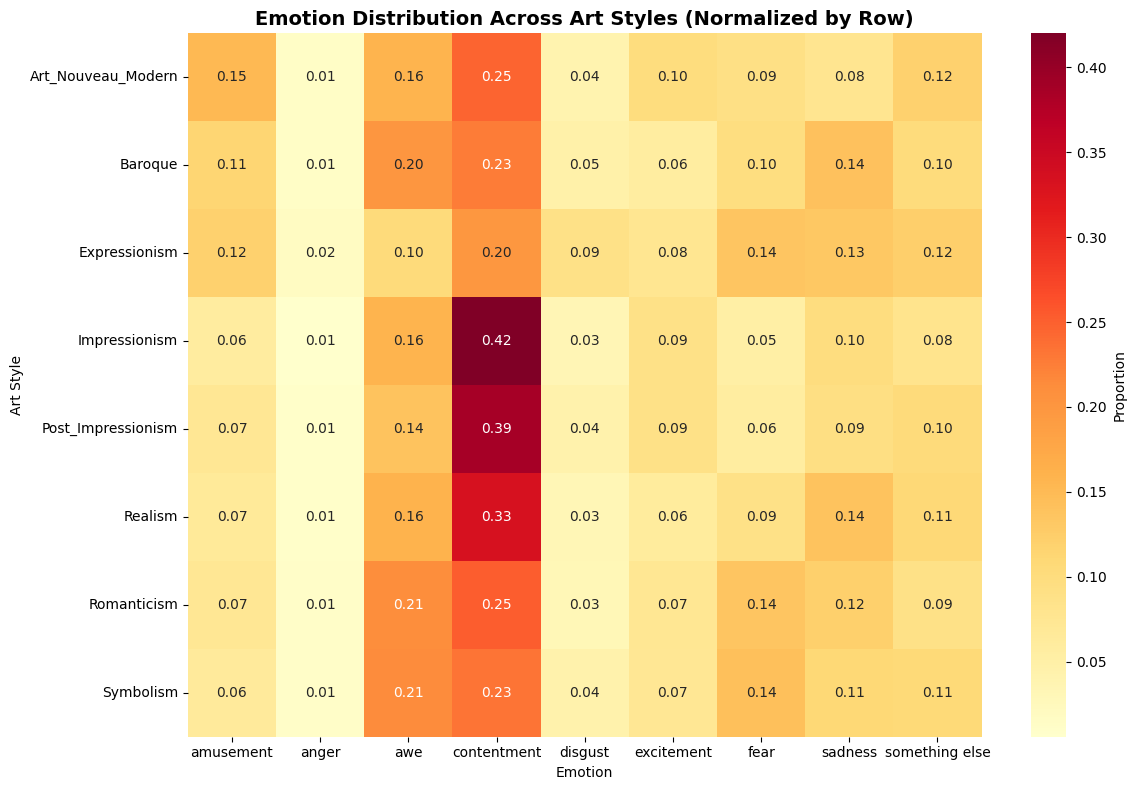

C:\Users\nicol\AppData\Local\Temp\ipykernel_40556\1487114559.py:258: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  style_diversity = df.groupby('style').apply(calc_diversity).sort_values(ascending=False).head(10)
C:\Users\nicol\AppData\Local\Temp\ipykernel_40556\1487114559.py:265: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emotion_diversity = df.groupby('emotion').apply(calc_diversity).sort_values(ascending=False)

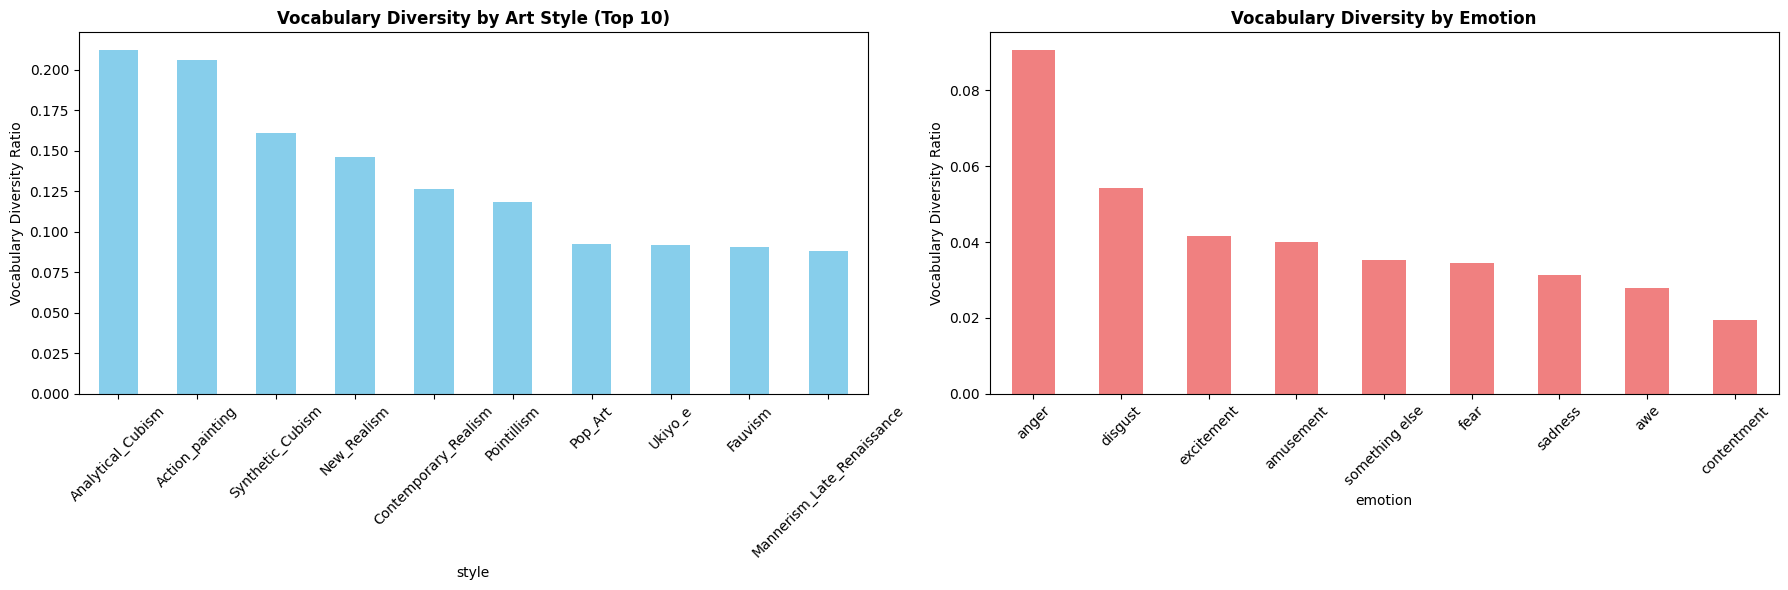


7. BASIC SENTIMENT ANALYSIS (Word-Based)
----------------------------------------
Average basic sentiment by emotion:
  contentment: 0.281
  excitement: 0.224
  awe: 0.213
  amusement: 0.114
  something else: 0.023
  disgust: -0.067
  anger: -0.160
  sadness: -0.238
  fear: -0.257

Average basic sentiment by style (top 5):
  Pointillism: 0.272
  Fauvism: 0.204
  Impressionism: 0.172
  Contemporary_Realism: 0.166
  Post_Impressionism: 0.160

8. UNIQUE INSIGHTS AND PATTERNS
----------------------------------------
Images with multiple captions: 80826
Average captions per multi-caption image: 5.77

Emotion variation for same images:
Images with single emotion: 1699
Images with multiple emotions: 79127

Most emotionally diverse styles:
  Abstract_Expressionism: 9 different emotions
  Action_painting: 9 different emotions
  Analytical_Cubism: 9 different emotions

Most common style-emotion combinations:
  Impressionism + contentment: 31041 captions
  Realism + contentment: 19733 captions
 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def analyze_style_emotion_patterns(df):
    """
    Comprehensive analysis of caption patterns across styles and emotions
    """
    print("=== CAPTION DIVERSITY AND PATTERNS ANALYSIS ===")
    print("=" * 60)
    
    # 1. Basic distribution analysis
    print("\n1. DATASET DISTRIBUTION")
    print("-" * 40)
    
    # Style distribution
    style_counts = df['style'].value_counts()
    print(f"Art Styles ({len(style_counts)} total):")
    for style, count in style_counts.head(10).items():
        print(f"  {style}: {count} captions ({count/len(df)*100:.1f}%)")
    
    # Emotion distribution
    emotion_counts = df['emotion'].value_counts()
    print(f"\nEmotions ({len(emotion_counts)} total):")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count} captions ({count/len(df)*100:.1f}%)")
    
    # 2. Caption length analysis by style and emotion
    print("\n2. CAPTION LENGTH PATTERNS")
    print("-" * 40)
    
    df['caption_length'] = df['caption'].apply(lambda x: len(str(x).split()))
    df['caption_chars'] = df['caption'].str.len()
    
    # By style
    style_lengths = df.groupby('style')['caption_length'].agg(['mean', 'std', 'count'])
    print("\nAverage caption length by style:")
    for style, row in style_lengths.sort_values('mean', ascending=False).head().iterrows():
        print(f"  {style}: {row['mean']:.1f} words (std: {row['std']:.1f}, n={row['count']})")
    
    # By emotion
    emotion_lengths = df.groupby('emotion')['caption_length'].agg(['mean', 'std', 'count'])
    print("\nAverage caption length by emotion:")
    for emotion, row in emotion_lengths.sort_values('mean', ascending=False).iterrows():
        print(f"  {emotion}: {row['mean']:.1f} words (std: {row['std']:.1f}, n={row['count']})")
    
    return style_lengths, emotion_lengths

def vocabulary_diversity_analysis(df):
    """
    Analyze vocabulary diversity across styles and emotions
    """
    print("\n3. VOCABULARY DIVERSITY ANALYSIS")
    print("-" * 40)
    
    def calculate_vocab_metrics(texts):
        all_words = []
        for text in texts:
            words = str(text).lower().split()
            all_words.extend(words)
        
        total_words = len(all_words)
        unique_words = len(set(all_words))
        vocab_diversity = unique_words / total_words if total_words > 0 else 0
        avg_word_length = sum(len(word) for word in all_words) / total_words if total_words > 0 else 0
        
        return {
            'total_words': total_words,
            'unique_words': unique_words,
            'vocab_diversity': vocab_diversity,
            'avg_word_length': avg_word_length
        }
    
    # Analyze by style
    print("Vocabulary by Art Style:")
    style_vocab = {}
    for style in df['style'].unique()[:5]:  # Limit to top 5 for readability
        style_texts = df[df['style'] == style]['caption']
        metrics = calculate_vocab_metrics(style_texts)
        style_vocab[style] = metrics
        print(f"  {style}:")
        print(f"    Unique words: {metrics['unique_words']:,}")
        print(f"    Vocabulary diversity: {metrics['vocab_diversity']:.4f}")
        print(f"    Avg word length: {metrics['avg_word_length']:.2f} chars")
    
    # Analyze by emotion
    print("\nVocabulary by Emotion:")
    emotion_vocab = {}
    for emotion in df['emotion'].unique():
        emotion_texts = df[df['emotion'] == emotion]['caption']
        metrics = calculate_vocab_metrics(emotion_texts)
        emotion_vocab[emotion] = metrics
        print(f"  {emotion}:")
        print(f"    Unique words: {metrics['unique_words']:,}")
        print(f"    Vocabulary diversity: {metrics['vocab_diversity']:.4f}")
    
    return style_vocab, emotion_vocab

def content_pattern_analysis(df):
    """
    Analyze content patterns and themes across styles and emotions
    """
    print("\n4. CONTENT PATTERNS AND THEMES")
    print("-" * 40)
    
    # Common stop words
    stop_words = {
        'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
        'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been',
        'this', 'that', 'these', 'those', 'it', 'its', 'my', 'i', 'me'
    }
    
    def get_top_words(texts, n=10):
        all_words = []
        for text in texts:
            words = str(text).lower().split()
            words = [re.sub(r'[^\w]', '', word) for word in words]  # Remove punctuation
            words = [word for word in words if word not in stop_words and len(word) > 2]
            all_words.extend(words)
        
        return Counter(all_words).most_common(n)
    
    # Analyze by style
    print("Top words by Art Style:")
    for style in df['style'].unique()[:5]:  # Top 5 styles
        style_texts = df[df['style'] == style]['caption']
        top_words = get_top_words(style_texts, 8)
        words_str = ', '.join([f"{word}({count})" for word, count in top_words])
        print(f"  {style}: {words_str}")
    
    # Analyze by emotion
    print("\nTop words by Emotion:")
    for emotion in df['emotion'].unique():
        emotion_texts = df[df['emotion'] == emotion]['caption']
        top_words = get_top_words(emotion_texts, 6)
        words_str = ', '.join([f"{word}({count})" for word, count in top_words])
        print(f"  {emotion}: {words_str}")
    
    # Theme analysis by emotion
    print("\n5. THEME ANALYSIS BY EMOTION")
    print("-" * 40)
    
    # Define theme categories
    themes = {
        'nature': ['tree', 'forest', 'sky', 'water', 'mountain', 'flower', 'nature', 'woods'],
        'color': ['color', 'red', 'blue', 'green', 'yellow', 'black', 'white', 'dark', 'bright'],
        'emotion_words': ['happy', 'sad', 'angry', 'fear', 'love', 'beautiful', 'scary', 'gloomy'],
        'art_terms': ['abstract', 'shape', 'form', 'line', 'texture', 'painting', 'art'],
        'urban': ['city', 'building', 'street', 'urban', 'architecture', 'wall']
    }
    
    def analyze_themes(texts, theme_dict):
        theme_counts = {theme: 0 for theme in theme_dict}
        total_texts = len(texts)
        
        for text in texts:
            text_lower = str(text).lower()
            for theme, words in theme_dict.items():
                if any(word in text_lower for word in words):
                    theme_counts[theme] += 1
        
        # Convert to percentages
        theme_percentages = {theme: count/total_texts*100 for theme, count in theme_counts.items()}
        return theme_percentages
    
    print("Theme prevalence by emotion (% of captions containing theme words):")
    for emotion in df['emotion'].unique():
        emotion_texts = df[df['emotion'] == emotion]['caption']
        theme_results = analyze_themes(emotion_texts, themes)
        
        print(f"\n{emotion}:")
        for theme, percentage in theme_results.items():
            if percentage > 10:  # Only show themes present in >10% of captions
                print(f"  {theme}: {percentage:.1f}%")

def create_visualizations(df, style_lengths, emotion_lengths):
    """
    Create comprehensive visualizations
    """
    print("\n6. CREATING VISUALIZATIONS...")
    
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Plot 1: Caption length by style (top 10 styles)
    top_styles = df['style'].value_counts().head(10).index
    style_data = df[df['style'].isin(top_styles)]
    
    sns.boxplot(data=style_data, x='caption_length', y='style', ax=axes[0,0])
    axes[0,0].set_title('Caption Length Distribution by Art Style (Top 10)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Number of Words')
    axes[0,0].set_ylabel('Art Style')
    
    # Plot 2: Caption length by emotion
    sns.boxplot(data=df, x='caption_length', y='emotion', ax=axes[0,1])
    axes[0,1].set_title('Caption Length Distribution by Emotion', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Number of Words')
    axes[0,1].set_ylabel('Emotion')
    
    # Plot 3: Style distribution
    style_counts = df['style'].value_counts().head(15)
    axes[1,0].barh(range(len(style_counts)), style_counts.values)
    axes[1,0].set_yticks(range(len(style_counts)))
    axes[1,0].set_yticklabels(style_counts.index)
    axes[1,0].set_title('Top 15 Art Styles by Number of Captions', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Number of Captions')
    
    # Plot 4: Emotion distribution
    emotion_counts = df['emotion'].value_counts()
    axes[1,1].bar(range(len(emotion_counts)), emotion_counts.values, color='lightcoral')
    axes[1,1].set_xticks(range(len(emotion_counts)))
    axes[1,1].set_xticklabels(emotion_counts.index, rotation=45)
    axes[1,1].set_title('Emotion Distribution', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Number of Captions')
    
    plt.tight_layout()
    plt.show()
    
    # Additional specialized visualizations
    create_specialized_visualizations(df)

def create_specialized_visualizations(df):
    """
    Create more specialized visualizations
    """
    # Style-Emotion heatmap
    plt.figure(figsize=(12, 8))
    
    # Create cross-tabulation
    top_styles = df['style'].value_counts().head(8).index
    filtered_df = df[df['style'].isin(top_styles)]
    cross_tab = pd.crosstab(filtered_df['style'], filtered_df['emotion'], normalize='index')
    
    sns.heatmap(cross_tab, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Proportion'})
    plt.title('Emotion Distribution Across Art Styles (Normalized by Row)', fontsize=14, fontweight='bold')
    plt.xlabel('Emotion')
    plt.ylabel('Art Style')
    plt.tight_layout()
    plt.show()
    
    # Vocabulary diversity by style and emotion
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Calculate vocabulary diversity
    def calc_diversity(group):
        all_words = ' '.join(group['caption'].astype(str).str.lower()).split()
        unique_words = len(set(all_words))
        return unique_words / len(all_words) if all_words else 0
    
    # By style
    style_diversity = df.groupby('style').apply(calc_diversity).sort_values(ascending=False).head(10)
    style_diversity.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Vocabulary Diversity by Art Style (Top 10)', fontweight='bold')
    ax1.set_ylabel('Vocabulary Diversity Ratio')
    ax1.tick_params(axis='x', rotation=45)
    
    # By emotion
    emotion_diversity = df.groupby('emotion').apply(calc_diversity).sort_values(ascending=False)
    emotion_diversity.plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Vocabulary Diversity by Emotion', fontweight='bold')
    ax2.set_ylabel('Vocabulary Diversity Ratio')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def basic_sentiment_analysis(df):
    """
    Basic sentiment analysis without TextBlob using word lists
    """
    print("\n7. BASIC SENTIMENT ANALYSIS (Word-Based)")
    print("-" * 40)
    
    # Simple sentiment word lists
    positive_words = {
        'beautiful', 'love', 'amazing', 'wonderful', 'happy', 'joy', 'nice', 'good',
        'great', 'excellent', 'fantastic', 'bright', 'colorful', 'peaceful', 'calm'
    }
    
    negative_words = {
        'sad', 'dark', 'scary', 'fear', 'angry', 'gloomy', 'bad', 'terrible',
        'horrible', 'ugly', 'confusing', 'chaotic', 'violent', 'disturbing'
    }
    
    def calculate_sentiment_score(text):
        text_lower = str(text).lower()
        words = text_lower.split()
        
        pos_count = sum(1 for word in words if word in positive_words)
        neg_count = sum(1 for word in words if word in negative_words)
        
        total_sentiment_words = pos_count + neg_count
        if total_sentiment_words == 0:
            return 0  # Neutral
        
        return (pos_count - neg_count) / total_sentiment_words
    
    df['basic_sentiment'] = df['caption'].apply(calculate_sentiment_score)
    
    # Analyze by emotion
    print("Average basic sentiment by emotion:")
    emotion_sentiment = df.groupby('emotion')['basic_sentiment'].mean().sort_values(ascending=False)
    for emotion, sentiment in emotion_sentiment.items():
        print(f"  {emotion}: {sentiment:.3f}")
    
    # Analyze by style
    print("\nAverage basic sentiment by style (top 5):")
    style_sentiment = df.groupby('style')['basic_sentiment'].mean().sort_values(ascending=False).head()
    for style, sentiment in style_sentiment.items():
        print(f"  {style}: {sentiment:.3f}")

def unique_insights(df):
    """
    Generate unique insights about the dataset
    """
    print("\n8. UNIQUE INSIGHTS AND PATTERNS")
    print("-" * 40)
    
    # Multiple captions per image analysis
    image_caption_counts = df.groupby('full_path')['caption'].nunique()
    multi_caption_images = image_caption_counts[image_caption_counts > 1]
    
    print(f"Images with multiple captions: {len(multi_caption_images)}")
    print(f"Average captions per multi-caption image: {multi_caption_images.mean():.2f}")
    
    # Analyze emotion consistency for same images
    print("\nEmotion variation for same images:")
    image_emotion_counts = df.groupby('full_path')['emotion'].nunique()
    print(f"Images with single emotion: {(image_emotion_counts == 1).sum()}")
    print(f"Images with multiple emotions: {(image_emotion_counts > 1).sum()}")
    
    # Most diverse styles (in terms of emotions)
    style_emotion_diversity = df.groupby('style')['emotion'].nunique().sort_values(ascending=False)
    print(f"\nMost emotionally diverse styles:")
    for style, diversity in style_emotion_diversity.head(3).items():
        print(f"  {style}: {diversity} different emotions")
    
    # Style-emotion combinations
    print(f"\nMost common style-emotion combinations:")
    style_emotion_combo = df.groupby(['style', 'emotion']).size().sort_values(ascending=False).head(5)
    for (style, emotion), count in style_emotion_combo.items():
        print(f"  {style} + {emotion}: {count} captions")

# Main execution function
def comprehensive_pattern_analysis(df):
    """
    Run all analyses without TextBlob dependency
    """
    print("Starting comprehensive caption pattern analysis...")
    
    # Run all analyses
    style_lengths, emotion_lengths = analyze_style_emotion_patterns(df)
    style_vocab, emotion_vocab = vocabulary_diversity_analysis(df)
    content_pattern_analysis(df)
    create_visualizations(df, style_lengths, emotion_lengths)
    basic_sentiment_analysis(df)  # Using our basic version
    unique_insights(df)

# Run the analysis
comprehensive_pattern_analysis(df1)

# Inference for caption patterns across styles and emotions:

* *EMOTION IMBALANCE:* Significant class imbalance detected
  - Contentment (27.6%) dominates → 5.5x more than anger (1.5%)
  - Negative emotions underrepresented: anger (1.5%), disgust (5.0%)
  - May bias models toward positive sentiment

* *STYLE DIVERSITY:* Good coverage with 27 art styles
  - Impressionism (15.8%) and Realism (12.7%) most prevalent
  - Balanced long-tail distribution across other styles

* *CAPTION LENGTH VARIATION:*
  - 'Something else' emotion has longest captions (17.2 words)
  - Contentment has shortest (15.2 words) → more concise descriptions
  - Baroque style most verbose (16.1 words)

* *VOCABULARY DIVERSITY:*
  - Anger has highest vocabulary diversity (0.0928) → more unique word choices
  - Contentment has lowest (0.0207) → more repetitive language
  - Abstract styles (Abstract Expressionism) show richer vocabulary

* *DOMINANT COMBINATIONS:*
  - Impressionism + Contentment: 31,041 captions (most frequent pair)
  - Realism + Contentment: 19,733 captions
  - Suggests certain styles naturally evoke specific emotions

* *EMOTIONAL DIVERSITY:*
  - Abstract styles show highest emotional range (9 different emotions)
  - Indicates abstract art elicits more varied emotional responses
  - More representational styles may have clearer emotional associations

* *HIGH SUBJECTIVITY: 79,127 images have multiple emotions*
  - Average 5.77 captions per multi-caption image
  - Suggests significant interpretative variability
  - Art evokes personalized, subjective responses

* *DATA RICHNESS: Multiple perspectives per image provides:*
  - Training data for nuanced emotion understanding
  - Insight into emotional ambiguity in art interpretation


## Preprocessing Recommendations

1. ADDRESS CLASS IMBALANCE:
   • Upsample: anger, disgust emotions
   • Downsample: contentment or use class weights
   • Consider emotion grouping for balanced training

2. SENTIMENT-AWARE PROCESSING:
   • Use sentiment scores as additional features
   • Cluster emotions by sentiment polarity
   • Handle 'something else' category separately (neutral/mixed)


## EDA Findings



## 3. Preprocessing

## 4. Text Representation 

## 5. Model 1(CNN Training and Evaluation)

## 6. Model 2(Transformer Training and Evaluation)

## 7. Analysis and Evaluation

## 8. Conclusion

## 9. References